In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

In [4]:
file_path = "../data/raw/minimun_wage.csv"
# 인코딩을 'euc-kr'로 설정하여 파일 읽기
df = pd.read_csv(file_path, encoding='euc-kr')

# 1️⃣ '적용연도'를 datetime 형식으로 변환
df['적용연도(1년 지속)'] = pd.to_datetime(df['적용연도(1년 지속)'])
df
# # 2️⃣ 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(df['적용연도(1년 지속)'], df['시간급'], marker='o', color='green', linestyle='-', linewidth=2)
# plt.title('연도별 시간급 변화')
# plt.xlabel('적용연도')
# plt.ylabel('시간급 (원)')
# plt.gca().invert_yaxis()
# plt.grid(True)
# plt.xticks(rotation=45)  # X축 라벨 회전
# plt.show()

,적용연도(1년 지속),시간급,일급(8시간 기준),월급(209시간,인상률(인상액),심의,결정
0,2025-01-01,"10,030","80,240","2,096,270",1.7 (170),24.07.12,24.08.05
1,2024-01-01,"9,860","78,880","2,060,740",2.5 (240),23.07.19,23.08.04
2,2023-01-01,"9,620","76,960","2,010,580",5.0 (460),22.06.29,22.08.05
3,2022-01-01,"9,160","73,280","1,914,440",5.05 (440),21.07.12,21.08.05
4,2021-01-01,"8,720","69,760","1,822,480",1.5 (130),20.07.14,20.08.05
5,2020-01-01,"8,590","68,720","1,795,310",2.87 (240),19.07.12,19.08.05


[*********************100%***********************]  1 of 1 completed


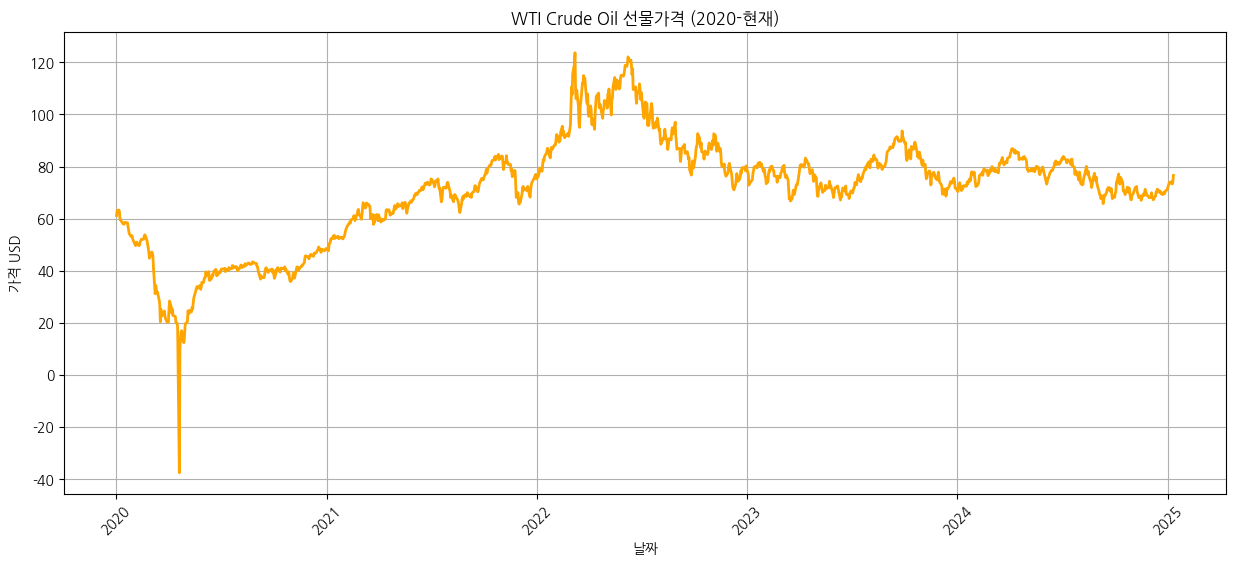

In [25]:
# 1️⃣ WTI Crude Oil 티커(symbol) 설정
oil_data = yf.download('CL=F', start='2020-01-01', end='2025-01-12')

# 2️⃣ 'Close' 가격을 기준으로 시각화
plt.figure(figsize=(15, 6))
plt.plot(oil_data.index, oil_data['Close'], color='orange', linewidth=2)
plt.title('WTI Crude Oil 선물가격 (2020-현재)')
plt.xlabel('날짜')
plt.ylabel('가격 USD')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

[*********************100%***********************]  1 of 1 completed


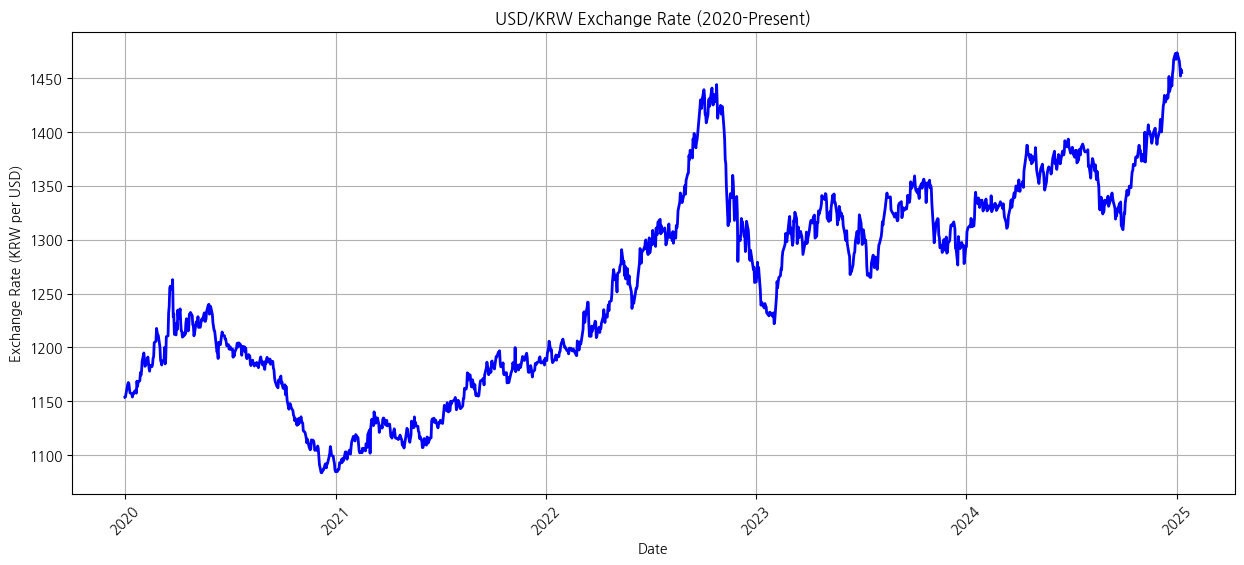

In [23]:
# 1️⃣ USD/KRW 환율 데이터 가져오기
krw_usd = yf.download('KRW=X', start='2020-01-01', end='2025-01-12')

# 2️⃣ 'Close' 가격을 기준으로 시각화
plt.figure(figsize=(15, 6))
plt.plot(krw_usd.index, krw_usd['Close'], color='blue', linewidth=2)
plt.title('USD/KRW 환율 (2020-Present)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (KRW per USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# WTO Tariff Database URL
url = 'https://www.wto.org/english/res_e/statis_e/statis_e.htm'

# 요청 보내기
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# 데이터 추출 (예제)
tables = soup.find_all('table')

# 테이블을 데이터프레임으로 변환
data = []
for table in tables:
    rows = table.find_all('tr')
    for row in rows:
        cols = [col.text.strip() for col in row.find_all('td')]
        if cols:
            data.append(cols)

# 데이터프레임 생성
df = pd.DataFrame(data)
print(df.head())

Empty DataFrame
Columns: []
Index: []


'../data/raw/금어기_데이터.csv'